# Predicting if a Patient has Diabetes or Not

## Business Understanding
 The objective of this project is to predict whether someone has diabetes or not.

## Data Understanding

- Pregnancies: Number of times a woman has been pregnant
- Glucose: Plasma Glucose concentration of 2 hours in an oral glucose tolerance test
- BloodPressure: Diastollic Blood Pressure (mm hg)
- SkinThickness: Triceps skin fold thickness(mm)
- Insulin: 2 hour serum insulin(mu U/ml)
- BMI: Body Mass Index ((weight in kg/height in m)^2)
- Age: Age(years)
- DiabetesPedigreeFunction: sores likelihood of diabetes based on family history) 
- Outcome: 0(doesn't have diabetes) or 1 (has diabetes) --> Our label


By observing the label, we can see that we're predicitng a binary classification: Whether someone has disbetes or not.

It raises the following observation: 
* If we predict that someone *has* diabetes (1) but actually they *don't* have diabetes (0) -> False Positive, this can lead to more tests, but to severe (for example, they won't get the medicine they need).

* However, if we predict that someone *doesn't* have diabetes (0) but actually they *do* have diabetes (1) -> False Negative, this can have severe implication as we missed that the patient actually has diabetes (needs medicine, proper care).

This would suggest us to use *recall* as the evaluation metric. (recall - out of all those who has diabetes, how many we predicted correctly).

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

from scipy.stats import randint, uniform, zscore, skew, stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import joblib

### Reading the Dataset and saving it in a dataframe variable named 'df'

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
# First 5 rows of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# This gives information about the data types,columns, null value counts, memory usage etc
#We mainly want to focus on the Dtype(data types), number of non-null values and number of rows.

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Key takeaways:
1. No categorical columns (no need to "OneHotEncoder")
2. No null values
3. Maybe 0 is our null value

In [5]:
# This gives us the number of rows in the dataset and number of columns. 
# The format is (# rows, # columns). We have here 768 rows, and 9 columns (including the label)

df.shape

(768, 9)

In [6]:
df.drop_duplicates(inplace=True)
df.shape

(768, 9)

### DataFrame.describe()
This method generates descriptive statistics that summarize our data distirbution. You can also think about it as how the data has been spread across the table.

Note! One important thing is that the describe() method deals only with numeric values. It doesn't work with any categorical values. So if there are any categorical values in a column the describe() method will ignore it and display summary for the other columns unless parameter include="all" is passed.

Examine the following fields:
* count: tells us the number of NoN-empty rows in a feature.
* mean: tells us the mean value of that feature. This also called Average.
* std: tells us the Standard Deviation Value of that feature.
* min: tells us the minimum value of that feature.
* 25%, 50%, and 75%: are the percentile/quartile of each features.
* max: tells us the maximum value of that feature.

In [7]:
df.describe()

# You can also "flip" (transpose) the table, such that the columns become rows and vice versa, buy using the '.T' command. 
# For example: df.describe().T
# It's just a matter of convenience

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## What do we learn from this table?

* Number of 0's and 1's is not equal - the mean (average) is 0.348 (Hint for Stratify, SMOTE)

* We observe that min value of some columns is 0 which cannot be possible. 
Thus, this indicates missing values. 
This means in the data preparation step we'll have to replace them with median/mean value depending on the distribution, or delete them.

Columns that have an invalid zero value:
1. Glucose
2. BloodPressure
3. SkinThickness
4. Insulin
5. BMI


* In max column we can see Insulin levels of 846, 17 pregencies and more. We can see that for example, that the mean (average) of the Insulin levels is app. 80, but there's a max value of 846.
Thus, indicating we have outliers.
This means we need to treat outliers.

### Key takeaways:
1. Data is *imbalanced*
2. Columns with problematic 0 value: Glucose, BloodPressure, SKinThickness, Insulin, BMI
3. We have Outliers
### ---------------

### Check if the label is imbalanced
If the data is imbalanced, it means that the number of 0 (people who don't have diabetes) is not equal to 1 (people who have diabetes). It's can affect on the model, as when we're splitting the data set, it can have more 0 (or 1) and the predication can be wrong. 

One way to approach this issue is to use Stratfied, where splitting the data set into train and test data. This will split the data in a equal manner of 0 and 1.

In [8]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

We can see that
(478/717)*100 = 66.66% for class 0
(239/717)*100 = 33.33% for class 1

Given these percentages, the dataset is moderately imbalanced.

A common threshold (don't be confused with the sigmoid threshold) to consider a dataset as imbalanced is when the minority class constitutes less than 20-30% of the total samples.

Here, class 1 (which is the minority class) constitutes approximately 33.33% of the samples, so it's just above that range.

#### Note that we can use SMOTE to try and overcome this imbalance (didn't use here as the dataset is considered small).
#### As the data is imbalanced we can't use accuracy as evaluation metric.

### Key takeaways:
1. Data is imbalanced
2. Split with Stratify
3. Not enough data for SMOTE
4. Can't use Accuracy as evalutation metric
### ---------------

## Visualize the data 
There are several type of plots we can use, this is how we can use them:
* Count Plot: to see if the dataset is balanced or not
* Histograms: to see if data is normally distributed (symmetric bell shape) or (skewed looks like a bell but is pushed to the right\left)
* Box Plot: to analyse the distribution and see the outliers
* Scatter plots: to understand relationship between any two variables
* Pair plot: to create scatter plot between all the variables

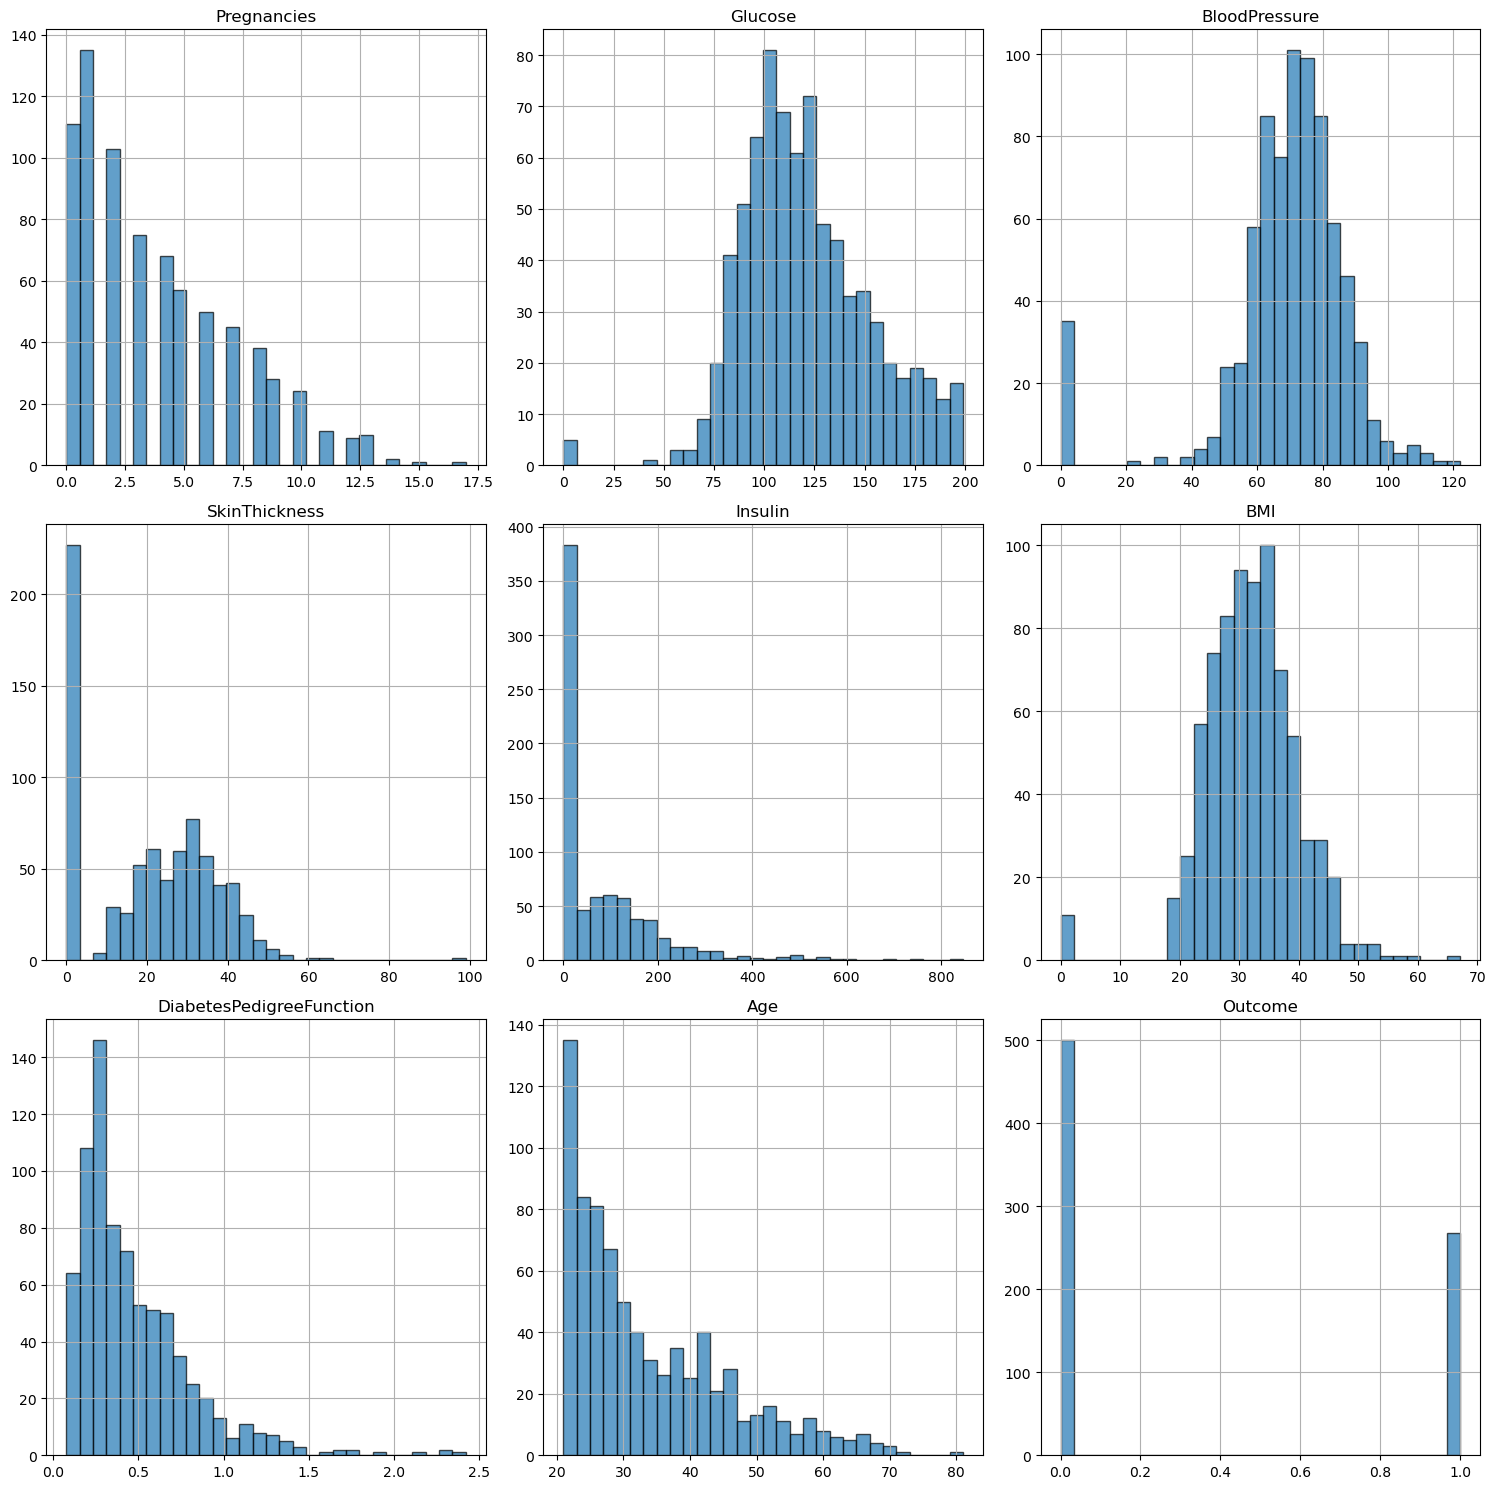

In [9]:
df.hist(figsize=(15, 15), bins=30, edgecolor='black', alpha=0.7)
plt.tight_layout()
plt.show()

### Key takeaways:
1. Some columns are normally distributed
2. Some columns seems Skewed
3. Notice the outliers and 0 values (null)
### ---------------

## Checking for Collinearity

Collinearity is a phenomenon in which one predictor(feature) variable in a regression model can be linearly predicted from the others with a high degree of accuracy. Models like Logistic Regression assumes the presence of non-collinearity among the features, if multicollinearity is present it can lead to the bad performance of such models.

Use Heatmap to check to Collinearity.

In a heatmap, we'll look for values which are high then 0.8 or smaller then -0.8. If we find values larger than 0.8 or smaller than -0.8 - it means our data is collinear. 

Models that shouldn't have Multicollinearity:
* Linear Regression
* Logistic Regression
* Multivariate Regression

By Observing our data heatmap we can that features don't have high correlations between them, which is good for us (most values are low)

<Axes: >

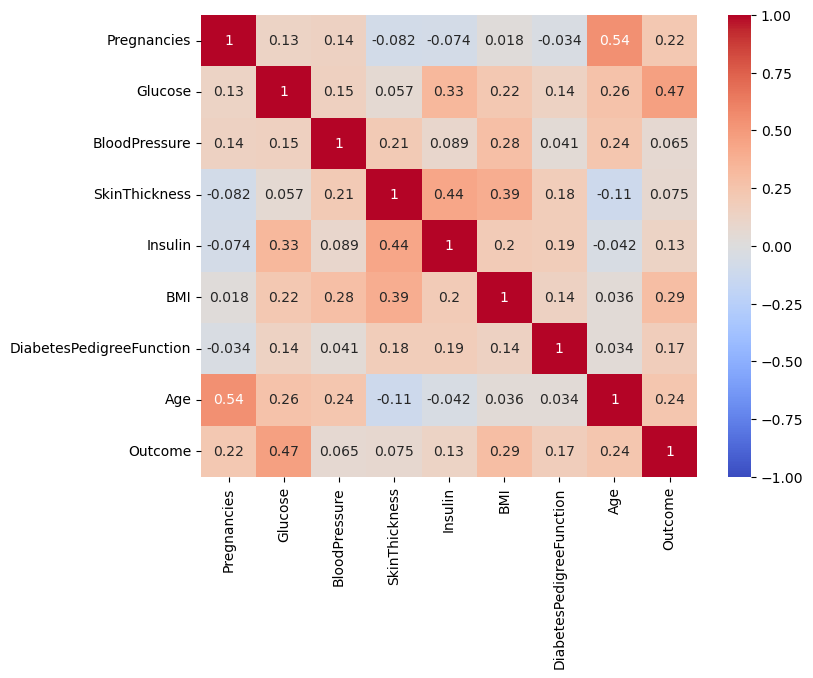

In [10]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Note the *Age* feture. We can think of it as older people get - higher the chances to have diabetes. We can see that it's relatively have high correlation with the Outcome (label). There, in order to handle the missing values, we can use "predictive imputation", which is based on Nueral Netwroks (NN). This means that the missing values are the label now (excluding the real label of the dataset) and we're predicitng it based on the current dataset. 
They do have some challenges:
* They require a significant amount of data to train effectively.
* They can be computationally expensive and time-consuming.
* They can be prone to overfitting, especially with smaller datasets.
* They require careful feature scaling and normalization.

## Checking for Multicollinearity
Multicollinearity, is similiar to Collinearity, but it invloves more features. Meaning, using 2 features, we can "predict" a third feature.

How to check for Multicollinearity? We'll use VIF and look for values that are high than 5 or 10. Ignore the first row (constant).


Models that shouldn't have Multicollinearity:
* Linear Regression
* Logistic Regression
* Multivariate Regression

In [11]:
# Add a constant to the features for VIF calculation
X_const = add_constant(df.drop('Outcome', axis=1))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

                    Feature        VIF
0                     const  35.039974
1               Pregnancies   1.430872
2                   Glucose   1.298961
3             BloodPressure   1.181863
4             SkinThickness   1.507432
5                   Insulin   1.427536
6                       BMI   1.297450
7  DiabetesPedigreeFunction   1.067090
8                       Age   1.588368


### Key takeaways:
1. Low dependency between features
2. No Collinearity
3. No Multicollinearity
4. LogisticRegression seems applicable to use
### ---------------

In [12]:
#Darwing histograms for distribution and skewness

def plot_histograms_with_skewness(data):
    # Define the number of rows needed for subplots based on the number of features
    n_rows = int(np.ceil(data.shape[1] / 3))

    # Create subplots
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 15))

    axes = axes.flatten()

    # Plot each feature's histogram and show skewness
    for ax, column in zip(axes, data.columns):
        data[column].hist(bins=30, edgecolor='black', alpha=0.7, ax=ax)
        skewness = data[column].skew()
        ax.set_title(f'{column} (Skewness: {skewness:.5f})')

    # Hide any empty subplot areas
    for i in range(data.shape[1], len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Data Preparations

## First, we're splitting the data

We'll do train test split with Stratified as our label is not balanced and we want to have the same ratio of 0 and 1 in the trainning set and test set, similar to the data set.

- The train-test split is a technique for evaluating the performance of a machine learning algorithm.

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the fit machine learning model.

- Common split percentages include:

Train: 80%, Test: 20%

Train: 75%, Test: 25%


I've used 80% train and 20% test

In [13]:
# We'll split the data into X as predictors and y as label
y = df['Outcome']
X = df.drop('Outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Key takeaways:
1. X_train, y_train
2. X_test, y_test
3. Stratify
### ---------------

To handle the missing values and outliers, we'll do it in the following steps:
#### 1.1 Handling missing - NaN
For the '0' values that we have in the columns mentioned (Glucose, BloodPressure, SkinThickness, Insulin and BMI), we'll replace it with NaN (as we saw that it doesn't make sense to have values of '0'). We first change it to NaN as we don't want these values to be taken into account in the next steps.


#### 1.2 Imputing in missing values
Fill in the missing values for the NaN Values.
* If the data the normally distiributed (looks like a symmetrical bell) - Use the *mean* (average) to fill the missing values.
* If the data is skewed (looks like a bell but is pushed to the right\left) - Use the *median* to fill the missing values.


#### 2. Handling skewness 
Handle skewed feature. This can be done for right skewed using Log Transformation, and for left skewed data raising to the power of 2 or 3 (applying exponent). Assuming the data has only positive values.


#### 3. Handling outliers  
Visualize the data and remove outliers based on the distribution (structure of the graph):
* If the data is normally distiributed (looks like a symmetrical bell) - Use z score.
* If the data is skewed (looks like a bell but is pushed to the right\left) - Use the IQR method.


#### 4. Scaling the data - StandardScaler() 
At the end, we'll use StandardScaler() for all features.

## 1.1. Handling missing values

In [14]:
# Handling missing (null) values
# From the observation before, we know that we have column that can't have value 0, which is considered as 'missing values'.

class ZeroToNanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()  # Make a copy of the input DataFrame to avoid changing it in-place
        if self.columns is not None:
            # If specific columns are provided, replace 0 with NaN only in those columns
            for col in self.columns:
                X_[col] = X_[col].replace(0, np.NaN)
        else:
            # If no columns are provided, replace 0 with NaN in all columns
            X_ = X_.replace(0, np.NaN)
        return X_

In [15]:
# Define the columns that need zero to NaN replacement
missing_values_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Zero to NaN Transformer Pipeline
zero_to_nan_pipeline = Pipeline([
    ('zero_to_nan', ZeroToNanTransformer(columns=missing_values_columns))
])

# Fit and transform the training data
X_train_zero_nan = zero_to_nan_pipeline.fit_transform(X_train)

# Transform the test data
X_test_zero_nan = zero_to_nan_pipeline.transform(X_test)


In [16]:
X_train_zero_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,12.0,43.0,27.2,0.580,24
711,5,126.0,78.0,27.0,22.0,29.6,0.439,40
373,2,105.0,58.0,40.0,94.0,34.9,0.225,25
46,1,146.0,56.0,NaN,NaN,29.7,0.564,29
682,0,95.0,64.0,39.0,105.0,44.6,0.366,22


### Key takeaways:
1. All 0 values are NaN
2. NaN values are not part of calculations
### ---------------

## 1.2. Imputing missing values

In [17]:
class SkewnessBasedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1):
        self.threshold = threshold
        self.imputers = {}  # Store the fitted imputers here

    def fit(self, X, y=None):
        # Compute the skewness of each column and decide on the imputation strategy
        for col in X.columns:
            col_skewness = skew(X[col].dropna())
            if abs(col_skewness) < self.threshold:
                strategy = 'mean'
            else:
                strategy = 'median'
            
            # Initialize the imputer with the strategy and fit it to the data
            self.imputers[col] = SimpleImputer(strategy=strategy)
            self.imputers[col].fit(X[[col]])

        return self

    def transform(self, X):
        X_ = X.copy()
        for col, imputer in self.imputers.items():
            # Use the fitted SimpleImputer for the column
            X_[[col]] = imputer.transform(X[[col]])
        return X_


In [18]:
# Skewness-Based Imputation Pipeline
imputation_pipeline = Pipeline([
    ('impute_skewness', SkewnessBasedImputer())
])

# Fit and transform the training data
X_train_imputed = imputation_pipeline.fit_transform(X_train_zero_nan)

# Transform the test data
X_test_imputed = imputation_pipeline.transform(X_test_zero_nan)


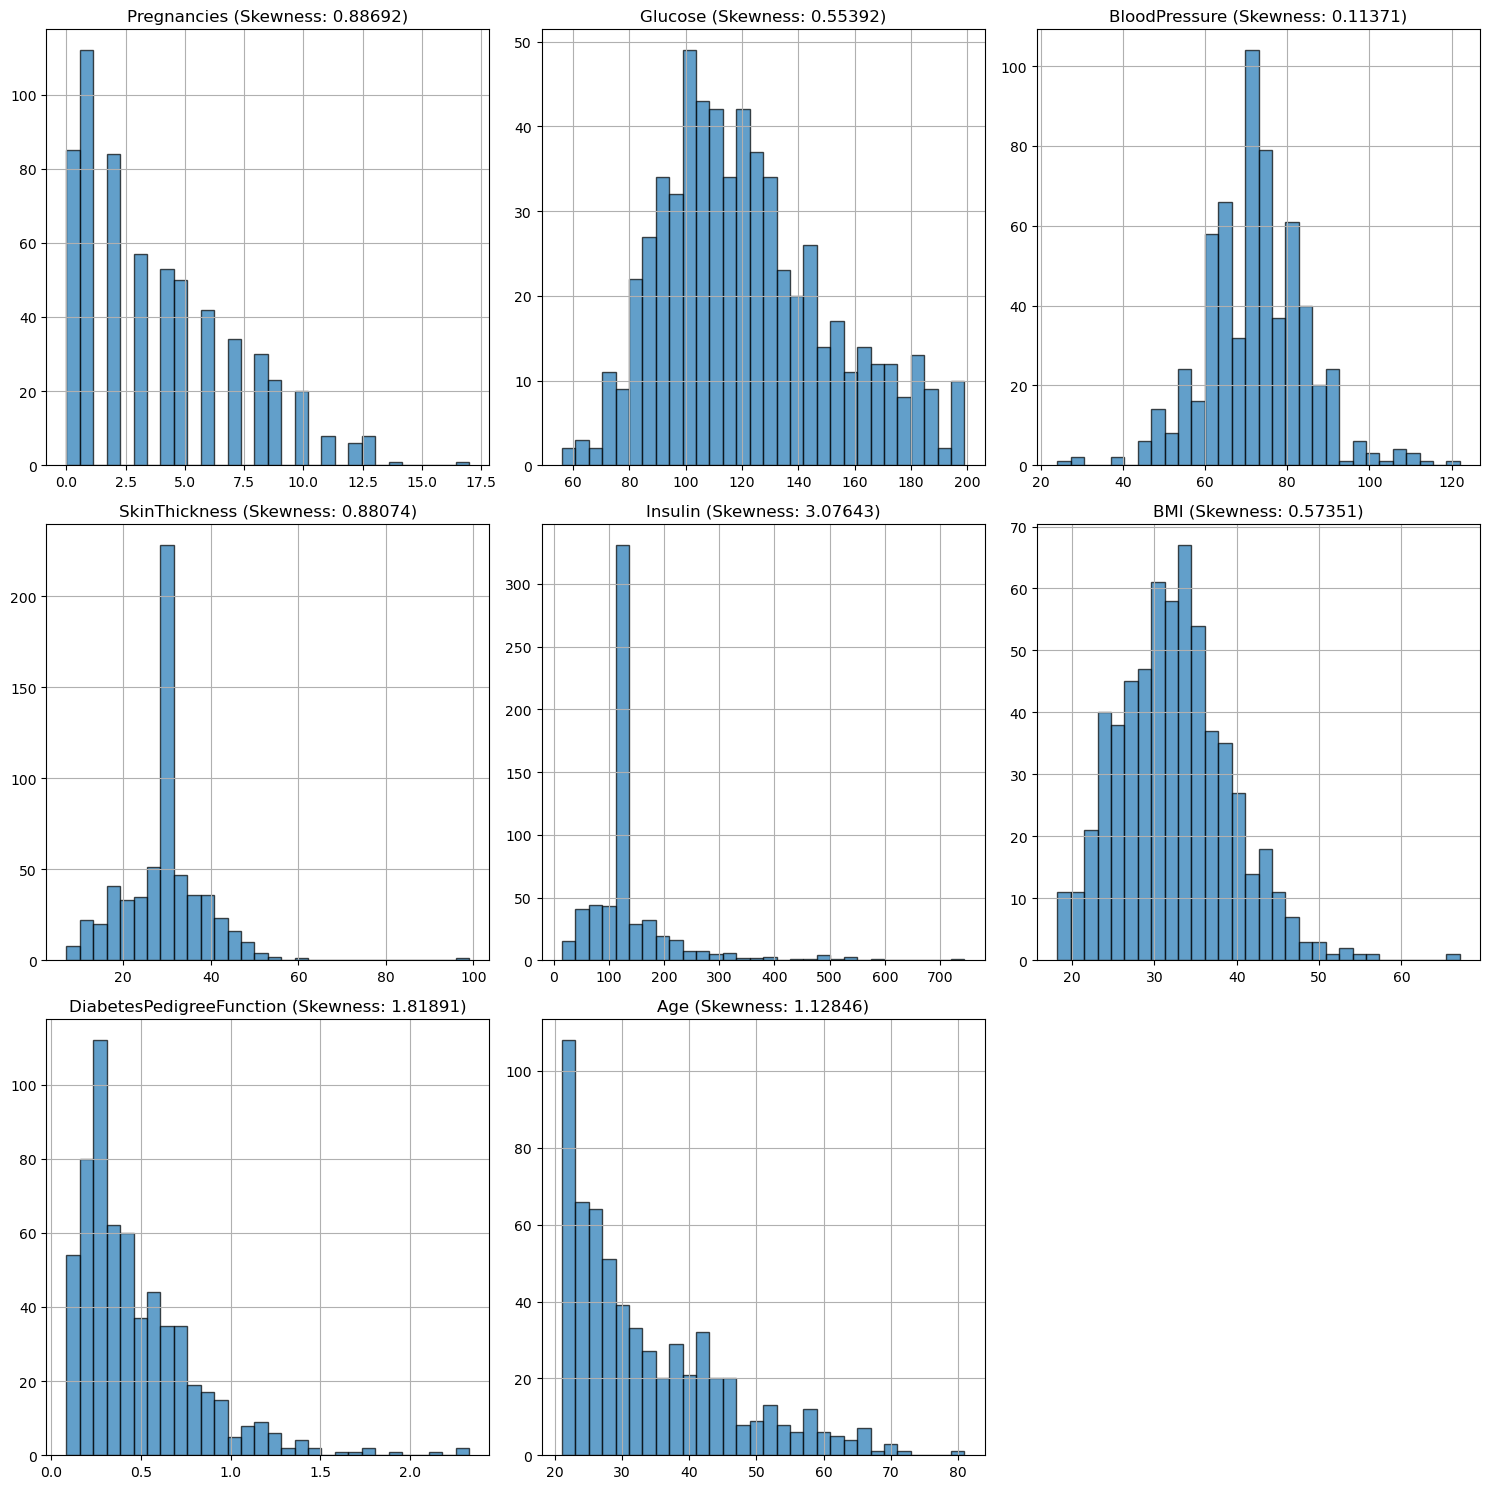

In [19]:
plot_histograms_with_skewness(X_train_imputed)

### Key takeaways:
1. Check Skewness levels of all features
2. if -1 < skew < 1 then NaN=mean, else NaN=median
### ---------------

## 3. Handling Skewness
Handle skewed feature. This can be done for right skewed using Log Transformation, and for left skewed data raising to the power of 2 or 3 (applying exponent). Assuming the data has only positive values.

Remember! skewness=0 doesn't mean it's normally distributed. All the values might be the same (for exmaple, all the value are 3). Always check visually (tables, graphs and etc).

In [20]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1):
        self.threshold = threshold
        self.skewed_features = []

    def fit(self, X, y=None):
        # Compute skewness directly without lambda or additional function calls
        for column in X:
            skewness = skew(X[column].dropna())
            if abs(skewness) > self.threshold:
                self.skewed_features.append(column)
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.skewed_features:
            # Apply log transformation, adding 1 to avoid log(0)
            X[feature] = np.log1p(X[feature])
        return X

In [21]:
# Log Transformation Pipeline
log_transform_pipeline = Pipeline([
    ('log_transform', LogTransformer())
])

# Fit and transform the training data
X_train_log_transformed = log_transform_pipeline.fit_transform(X_train_imputed)

# Transform the test data
X_test_log_transformed = log_transform_pipeline.transform(X_test_imputed)

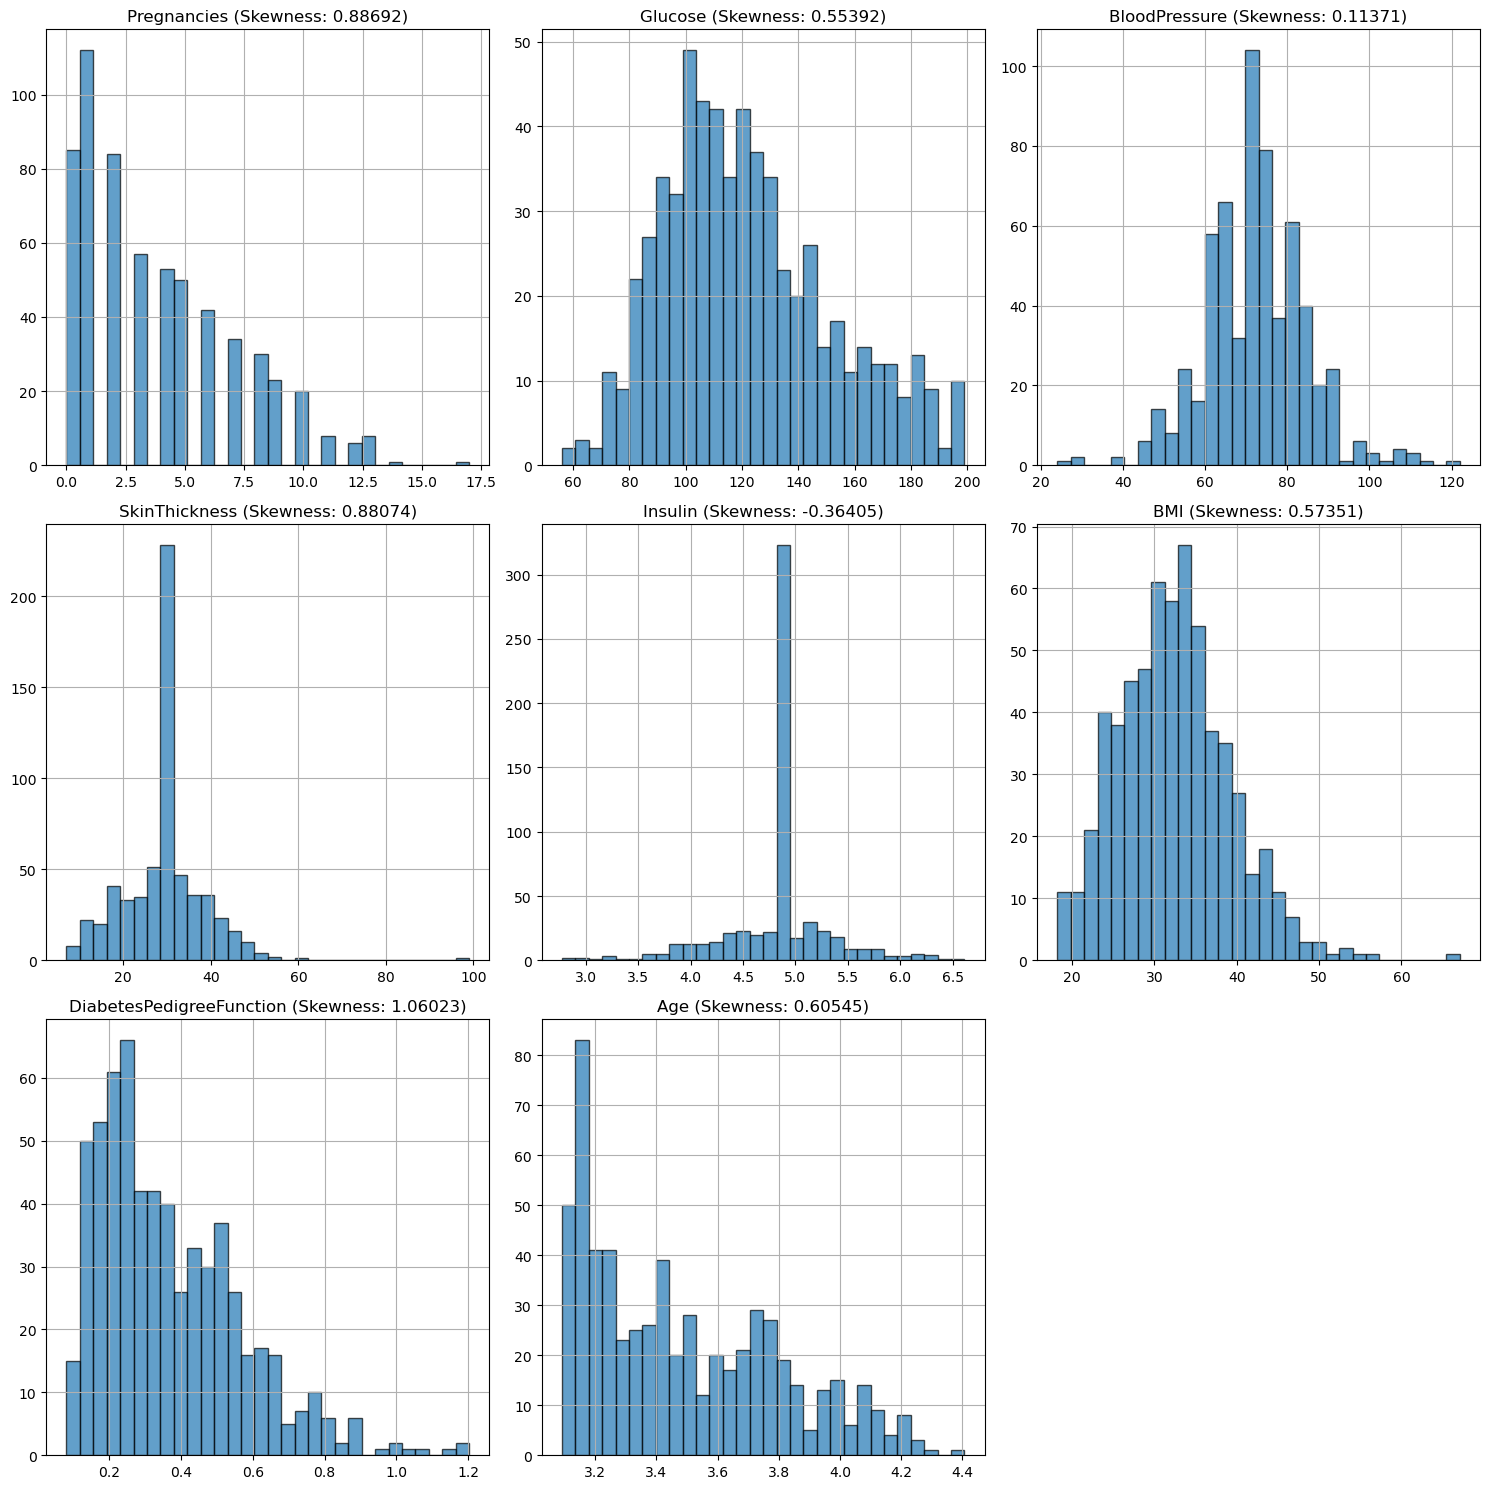

In [22]:
plot_histograms_with_skewness(X_train_log_transformed)

### Key takeaways:
1. LogTransform helps to reduce skewness
2. LogTransform can help deal with Outliers
### ---------------

## 2. Handling Outliers
Visualize the data and remove outliers based on the distribution (structure of the graph):
* If the data is normally distiributed (looks like a symmetrical bell) - Use z score.  Use Z-scores when your data is approximately normally distributed, and you want to identify outliers as data points that are a certain number of standard deviations away from the mean.

* If the data is skewed (looks like a bell but is pushed to the right\left) - Use the IQR method. IQR is useful when you deal with skewed data where using the mean and standard deviation is not appropriate because they are affected by outliers.

* Note that most of Scikit-learn method that handle outliers are scaling of the data, meaning minimizing the effect of the scalers. Here we're identifying the outliers and inserting different values to them.

Below is a list of algorithms from scikit learn and when to use them:
* RobustScaler - Best used with data that contains many outliers or when using algorithms sensitive to the scale of data, such as SVM, k-NN, and linear models.
* QuantileTransformer - Useful when you want to transform your features to follow a normal or uniform distribution which can improve the performance of linear models and neural networks.

In [23]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, z_thresh=3, iqr_multiplier=1.5):
        self.z_thresh = z_thresh
        self.iqr_multiplier = iqr_multiplier
        self.bounds_ = {}

    def fit(self, X, y=None):
        for column in X.columns:
            if abs(X[column].skew()) < 1:  # Normally distributed
                z_scores = zscore(X[column])
                upper_bound = X[column][(z_scores < self.z_thresh)].max()
                lower_bound = X[column][(z_scores > -self.z_thresh)].min()
            else:  # Skewed data
                Q1 = X[column].quantile(0.05)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - (self.iqr_multiplier * IQR)
                upper_bound = Q3 + (self.iqr_multiplier * IQR)
            self.bounds_[column] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        X_capped = X.copy()
        for column, (lower_bound, upper_bound) in self.bounds_.items():
            X_capped[column] = np.clip(X_capped[column], lower_bound, upper_bound)
        return X_capped

In [24]:
# Outlier Handling Pipeline
outlier_handling_pipeline = Pipeline([
    ('handle_outliers', OutlierHandler(z_thresh=3, iqr_multiplier=1.5))
])

# Fit and transform the training data
X_train_outliers_handled = outlier_handling_pipeline.fit_transform(X_train_log_transformed)

# We're not handling outliers for the test set! 
# Handling outlier is part of the data processing steps

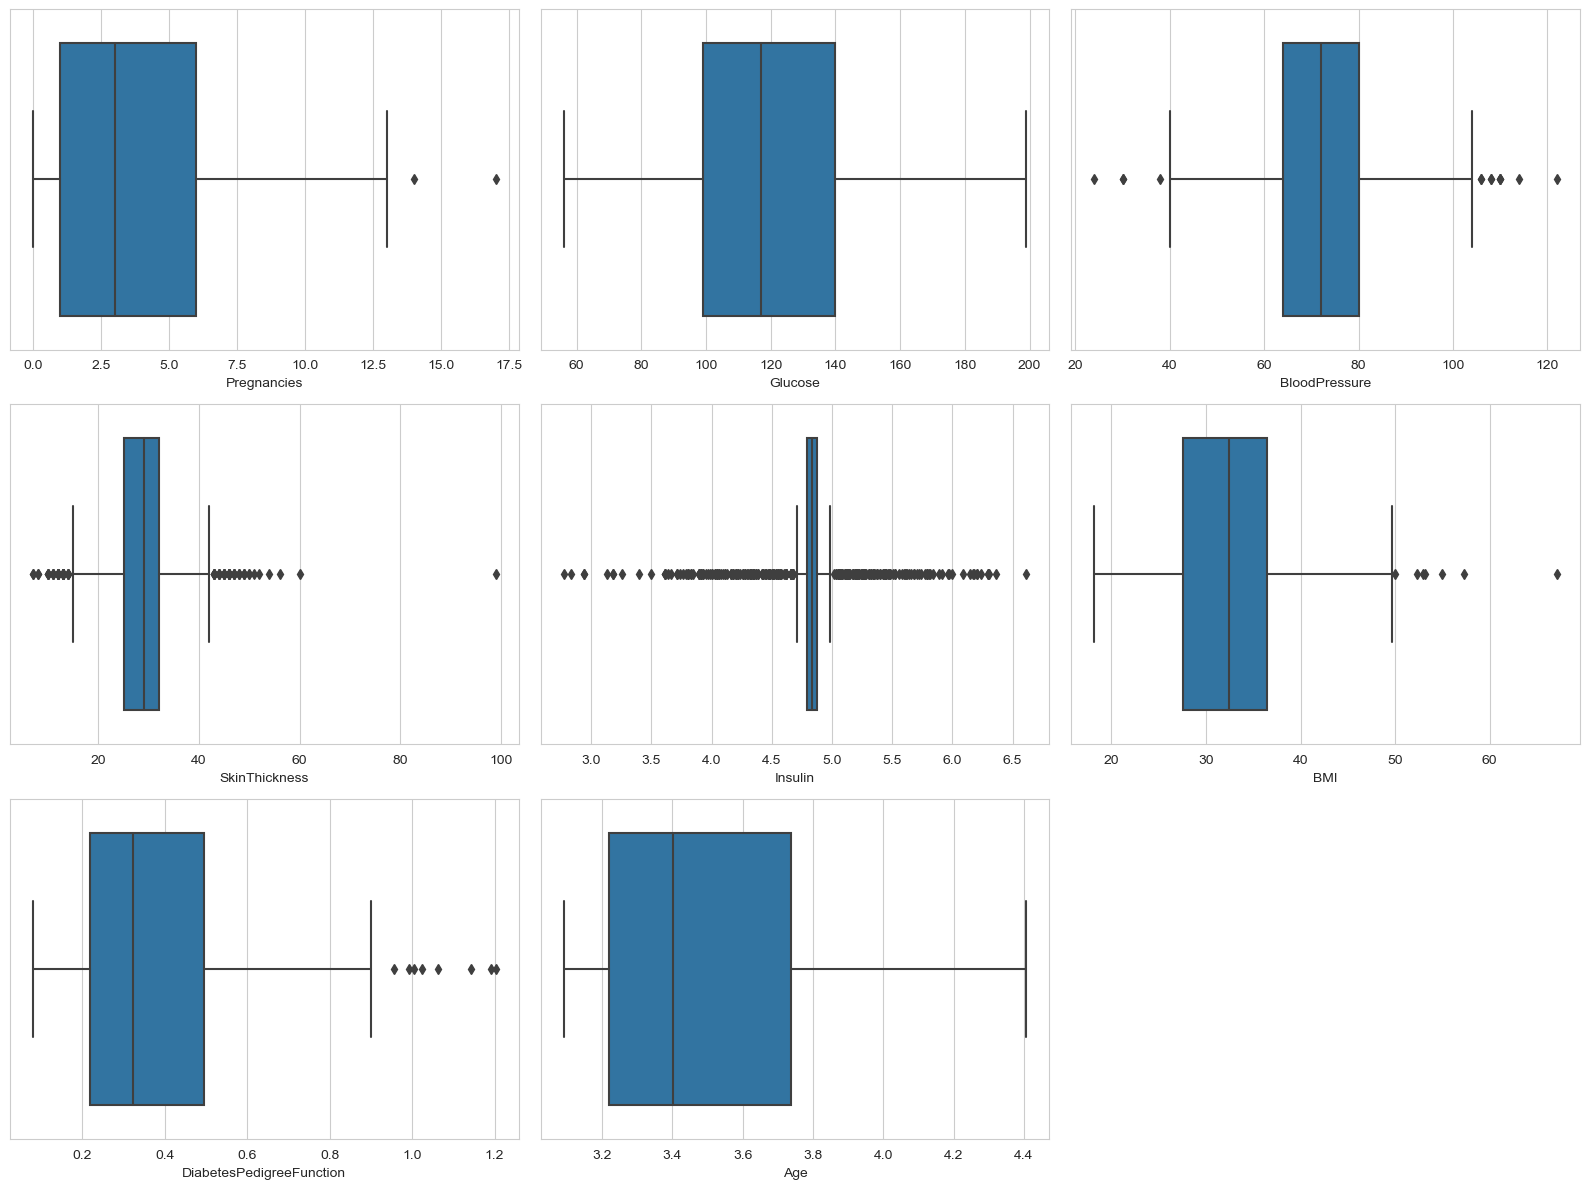

In [25]:
# Set the figure size and style
plt.figure(figsize=(16, 12))
sns.set_style(style='whitegrid')

for i, feature in enumerate(X_train_outliers_handled.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=feature, data=X_train_log_transformed)

plt.tight_layout()
plt.show() 

### Key takeaways:
1. Check skewness of features
2. if -1 < skew < 1 then z-score, else IQR
3. When dealing with outliers, we're changing it only for train set. We're changing outliers for the test set!
### ---------------

## 4. Scaling the data - StandardScaler()

In [26]:
class StandardScalerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        return self.scaler.transform(X)

In [27]:
# Standard Scaler Pipeline
standard_scaler_pipeline = Pipeline([
    ('scaler', StandardScalerWrapper())
])

# Fit and transform the training data
X_train_processed = standard_scaler_pipeline.fit_transform(X_train_outliers_handled)

# X_test_processed = standard_scaler_pipeline.transform(X_test_outliers_handled)
X_test_processed = standard_scaler_pipeline.transform(X_test_log_transformed)


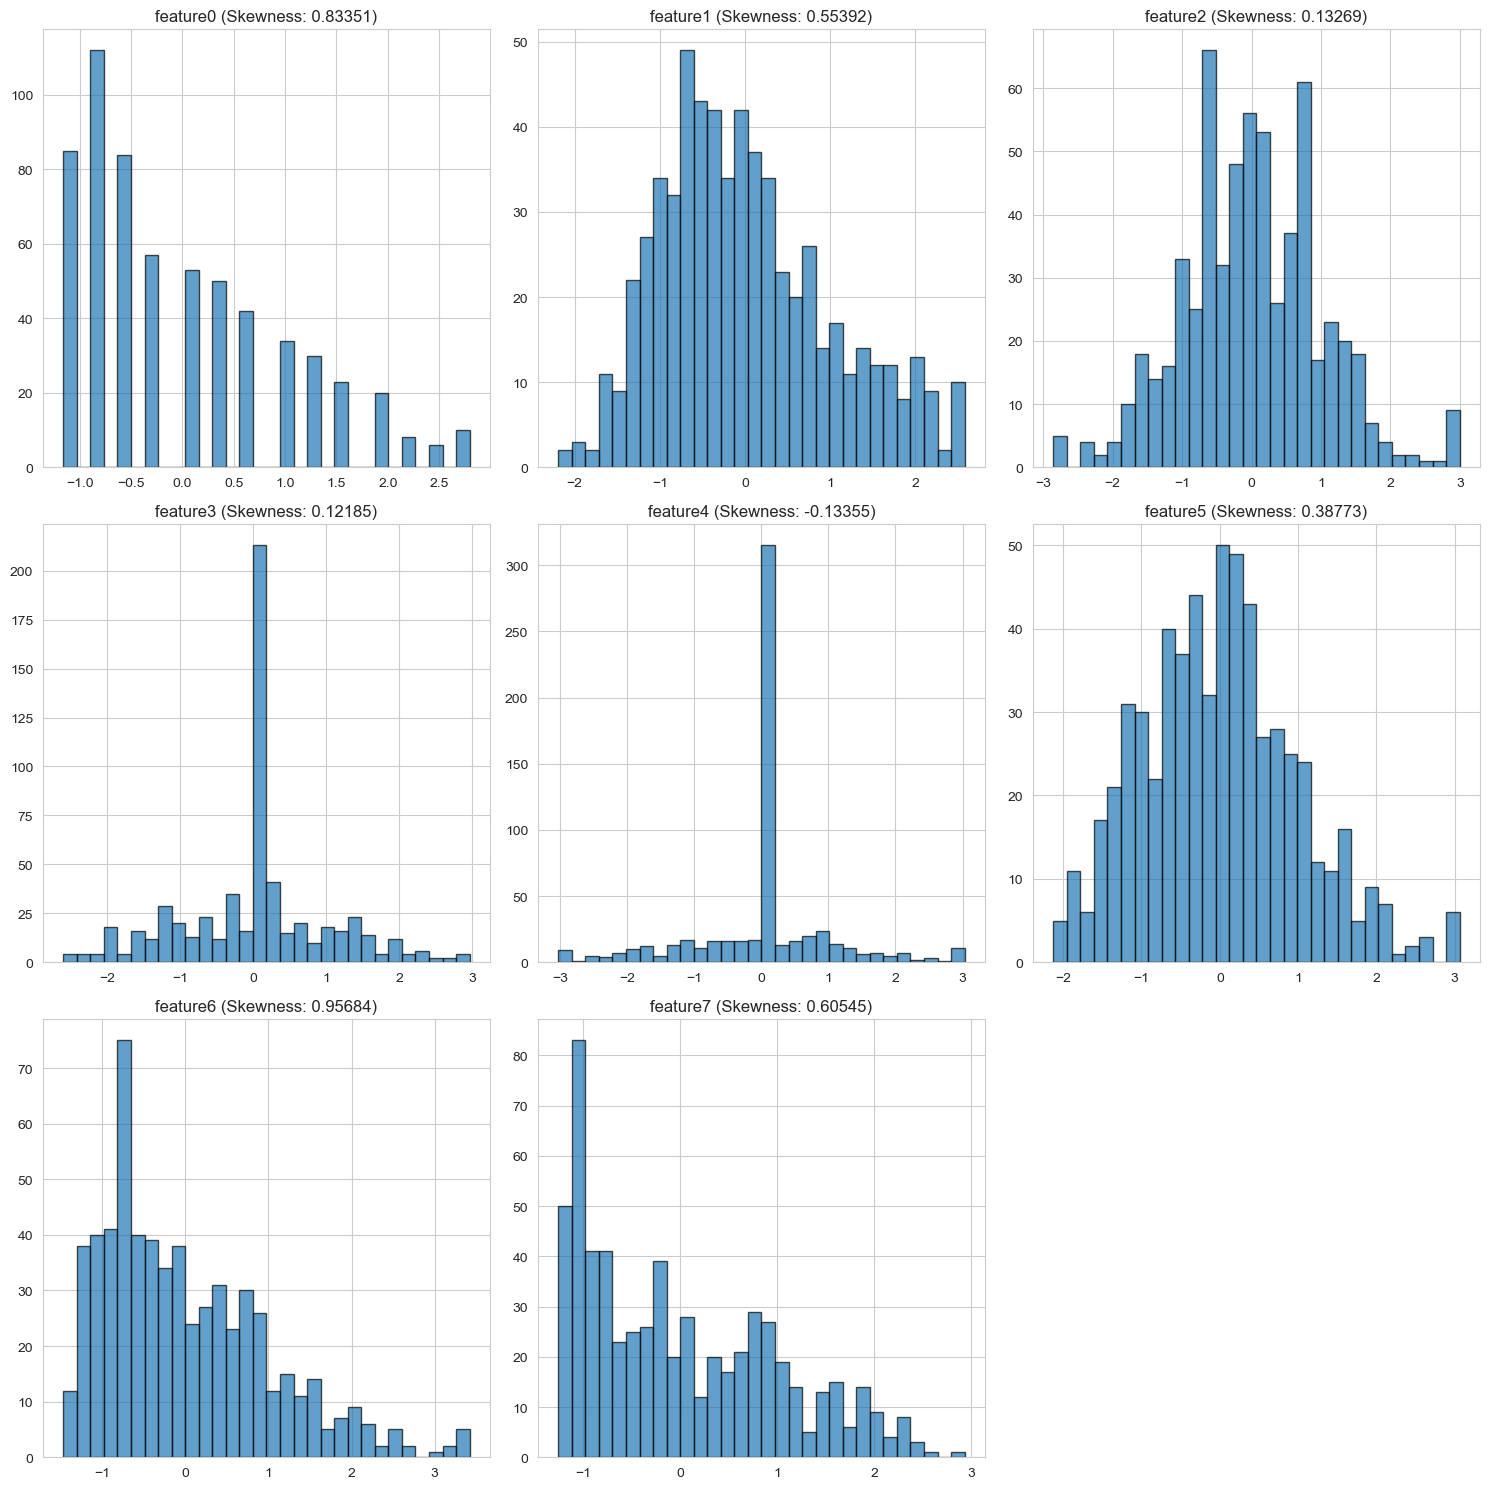

In [28]:
feature_names = [f'feature{i}' for i in range(X_train_processed.shape[1])]
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

plot_histograms_with_skewness(X_train_df)

### Key takeaways:
1. All features are now scaled
2. Use StandardScaler
### ---------------

####### Define the pipeline steps
missing_values_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

pipeline_steps = [
    ('zero_to_nan', ZeroToNanTransformer(columns=missing_values_columns)),
    ('imputer', SkewnessBasedImputer(threshold=1)),
    ('handle_outliers', OutlierHandler(z_thresh=3, iqr_multiplier=1.5)),
    ('log_transform', LogTransformer(threshold=1)),
    ('scaler', StandardScalerWrapper())
]

####### Create the main pipeline
main_pipeline = Pipeline(steps=pipeline_steps)

####### Fit the pipeline to the training data
main_pipeline.fit(X_train)

####### Apply the transformations to the training data
X_train_processed = main_pipeline.transform(X_train)

####### Apply the same transformations to the test data
X_test_processed = main_pipeline.transform(X_test)


# Modeling & Evaluation

# *****************
# *Now for the FUN part!*
# *****************

* Precision: This tells you what proportion of positive identifications was actually correct. You would use precision in contexts where the cost of a false positive is high. For example, in email spam detection, you would want to be very sure that an email you are classifying as spam is truly spam because you don't want to miss important emails.
##### 
* *Recall*: This tells you what proportion of actual positives was identified correctly. You would use recall in contexts where the cost of a false negative is high. For example, in fraud detection or disease screening, it's better to flag a transaction or a disease state that turns out to be a false alarm than to miss a true one. (missing positive case is critical)
##### 
* F1-Score: This is a combination of precision and recall into a single number. It's the harmonic mean of precision and recall and gives you a balance between them. You would use the F1-score in situations where you want to strike a balance between precision and recall, and there’s an uneven class distribution
#####
* Accuracy: (Not applicable here as the data is imbalanced) This tells you what proportion of the total cases was classified correctly. However, accuracy alone can be misleading if there is a class imbalance (e.g., 95% of the data is of one class). Therefore, it is often more useful when classes are balanced.
#####
Specifically, you might choose one metric over the other based on your project's needs:

If all classes are equally important: Macro Average.
If some classes are more important than others or there's class imbalance: Weighted Average.

#### Use GridSearchCV when:
* Your dataset is relatively small and can be processed quickly (less than 10,000 samples)
* You don't have a large number of hyperparameters.
* You want to be thorough and are willing to wait for the results.
* You have a strong computer to have the thorough search.

#### Use RandomizedSearchCV when:
* You are working with a large dataset and/or a complex model. (more than 10,000 samples)
* The hyperparameter space is large.
* You have limited time and computational resources. (faster than GridSearchCV)
* You want a good enough set of parameters and can tolerate the chance of not getting the absolute best.


Another method is to start with RandomizedSearchCV and than continue to GridSearchCV with better understanding of the hyperparameters.

In [29]:
def plot_evaluation_metrics(clf_name, y_true_train, y_pred_train, y_pred_proba_train, y_true_test, y_pred_test, y_pred_proba_test):
    # Create a figure for the confusion matrices and ROC curves
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion matrix for the training set
    train_confusion_matrix = confusion_matrix(y_true_train, y_pred_train)
    # Confusion matrix for the test set
    test_confusion_matrix = confusion_matrix(y_true_test, y_pred_test)

    # Plot the confusion matrix for training set
    sns.heatmap(train_confusion_matrix, annot=True, fmt='d', ax=ax[0, 0], cmap='Blues', annot_kws={"size": 16})
    ax[0, 0].set_title(f'Training Set Confusion Matrix: {clf_name}', fontsize=14)
    ax[0, 0].set_xlabel('Predicted labels')
    ax[0, 0].set_ylabel('True labels')

    # Plot the confusion matrix for test set
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', ax=ax[0, 1], cmap='Blues',annot_kws={"size": 16})
    ax[0, 1].set_title(f'Test Set Confusion Matrix: {clf_name}', fontsize=14)
    ax[0, 1].set_xlabel('Predicted labels')
    ax[0, 1].set_ylabel('True labels')

    # Calculate and plot ROC curve for train set
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax[1, 0].plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
    ax[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1, 0].set_xlim([0, 1])
    ax[1, 0].set_ylim([0, 1])
    ax[1, 0].set_xlabel('False Positive Rate', fontsize=14)
    ax[1, 0].set_ylabel('True Positive Rate', fontsize=14)
    ax[1, 0].set_title(f'Training Set ROC & AUC: {clf_name}', fontsize=14)
    ax[1, 0].legend(loc="lower right", fontsize=12)

    # Calculate and plot ROC curve for test set
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax[1, 1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
    ax[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1, 1].set_xlim([0, 1])
    ax[1, 1].set_ylim([0, 1])
    ax[1, 1].set_xlabel('False Positive Rate', fontsize=14)
    ax[1, 1].set_ylabel('True Positive Rate', fontsize=14)
    ax[1, 1].set_title(f'Test Set ROC & AUC: {clf_name}', fontsize=14)
    ax[1, 1].legend(loc="lower right", fontsize=12)

    
    # Show the plots
    plt.tight_layout()
    plt.show()

    # Print classification reports side by side
    report_train = classification_report(y_true_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_true_test, y_pred_test, output_dict=True)
    
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(f"Classification Report for {clf_name} Training Set:")
    print(pd.DataFrame(report_train).transpose())
    print("\n")
    print(f"Classification Report for {clf_name} Test Set:")
    print(pd.DataFrame(report_test).transpose())
    print("-" * 60)



In [30]:
# Define parameter grids for different classifiers
param_grid = {
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l2'],
        'max_iter': [1000]
    },
    'KNeighborsClassifier': {
        'n_neighbors': range(3, 15),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Define the number of folds for cross-validation
cv_folds = 5

# Initialize dictionary to store best models
best_models = {}

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier()
]


def evaluate_classifiers(X_train, y_train, X_test, y_test, classifiers, param_grid, cv_folds):
    best_logreg_model = None
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"Starting search for {clf_name}")
        
        search_cv = GridSearchCV(clf, param_grid[clf_name], cv=cv_folds, scoring='recall', verbose=0)
        search_cv.fit(X_train, y_train)
        best_clf = search_cv.best_estimator_
        
        # Store the best Logistic Regression model
        if clf_name == 'LogisticRegression':
            best_logreg_model = best_clf       
        
        # Predict on the train set
        y_train_pred = best_clf.predict(X_train)
        y_train_pred_proba = best_clf.predict_proba(X_train)[:, 1]
        
        # Predict on the test set using the best model
        y_pred = best_clf.predict(X_test)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        
        plot_evaluation_metrics(clf_name, y_train, y_train_pred, y_train_pred_proba, y_test, y_pred, y_pred_proba)

    return best_logreg_model

Starting search for LogisticRegression


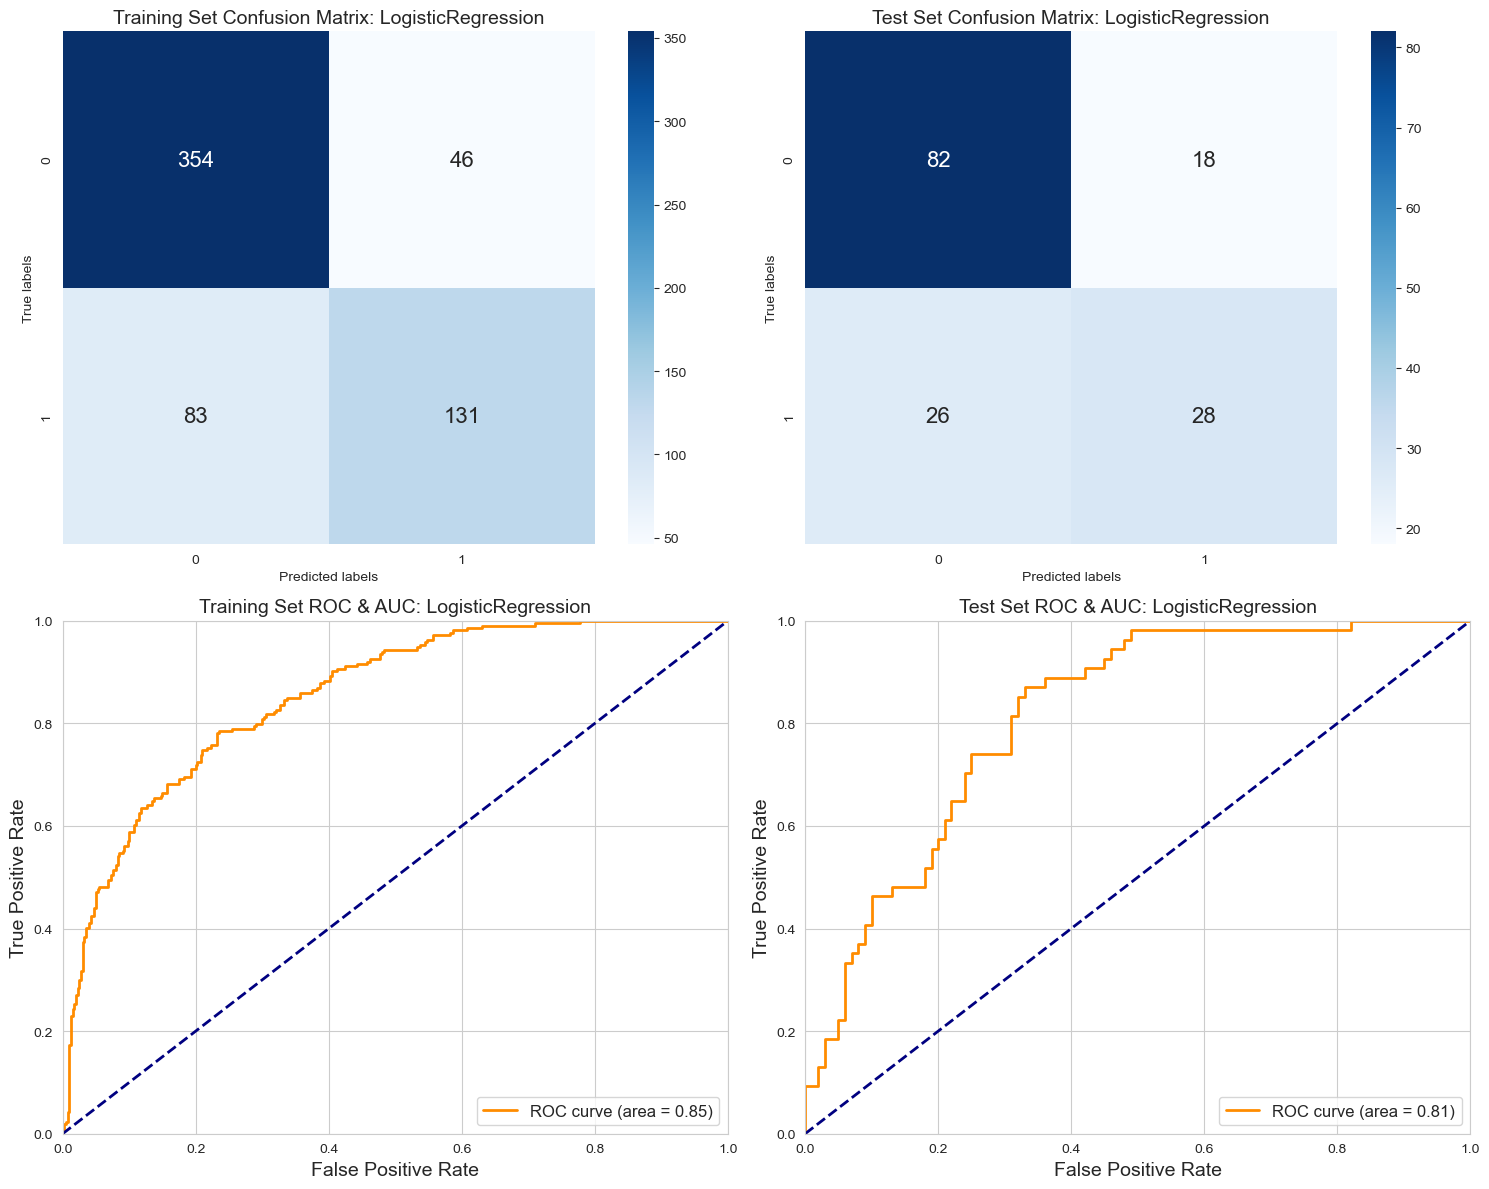

Classification Report for LogisticRegression Training Set:
              precision  recall  f1-score  support
0                  0.81    0.89      0.85   400.00
1                  0.74    0.61      0.67   214.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.78    0.75      0.76   614.00
weighted avg       0.79    0.79      0.78   614.00


Classification Report for LogisticRegression Test Set:
              precision  recall  f1-score  support
0                  0.76    0.82      0.79   100.00
1                  0.61    0.52      0.56    54.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.68    0.67      0.67   154.00
weighted avg       0.71    0.71      0.71   154.00
------------------------------------------------------------
Starting search for KNeighborsClassifier


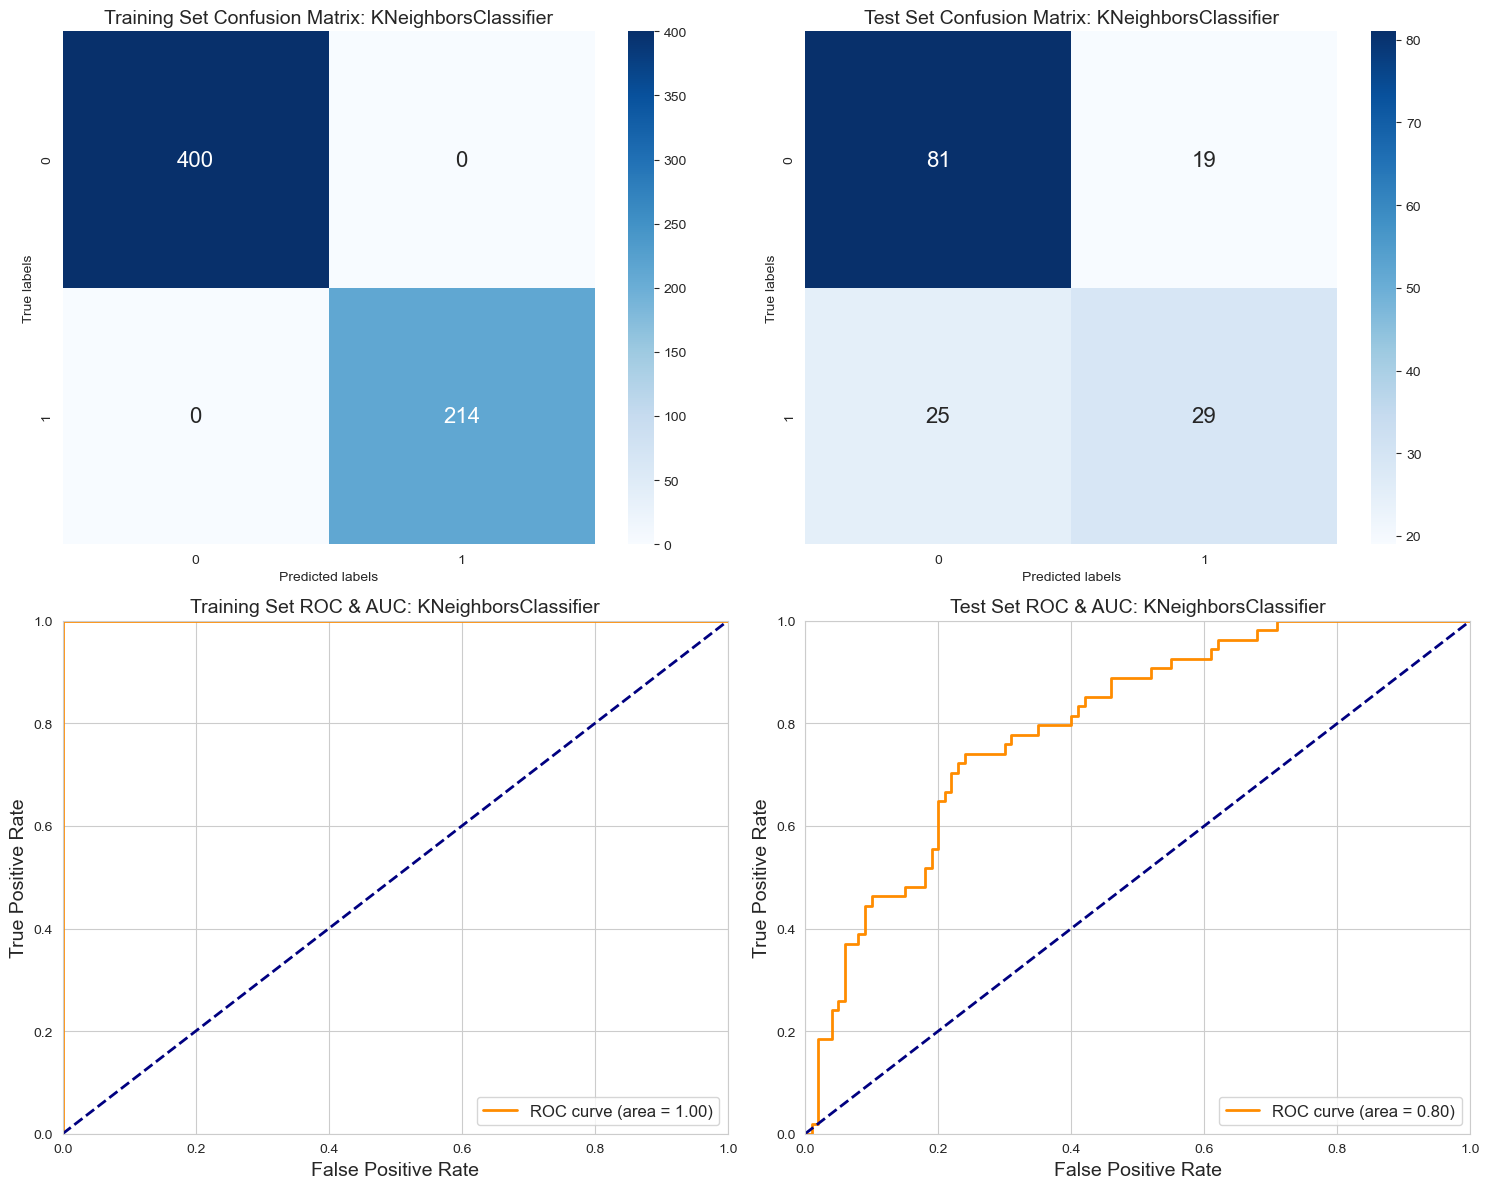

Classification Report for KNeighborsClassifier Training Set:
              precision  recall  f1-score  support
0                  1.00    1.00      1.00   400.00
1                  1.00    1.00      1.00   214.00
accuracy           1.00    1.00      1.00     1.00
macro avg          1.00    1.00      1.00   614.00
weighted avg       1.00    1.00      1.00   614.00


Classification Report for KNeighborsClassifier Test Set:
              precision  recall  f1-score  support
0                  0.76    0.81      0.79   100.00
1                  0.60    0.54      0.57    54.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.68    0.67      0.68   154.00
weighted avg       0.71    0.71      0.71   154.00
------------------------------------------------------------
Starting search for DecisionTreeClassifier


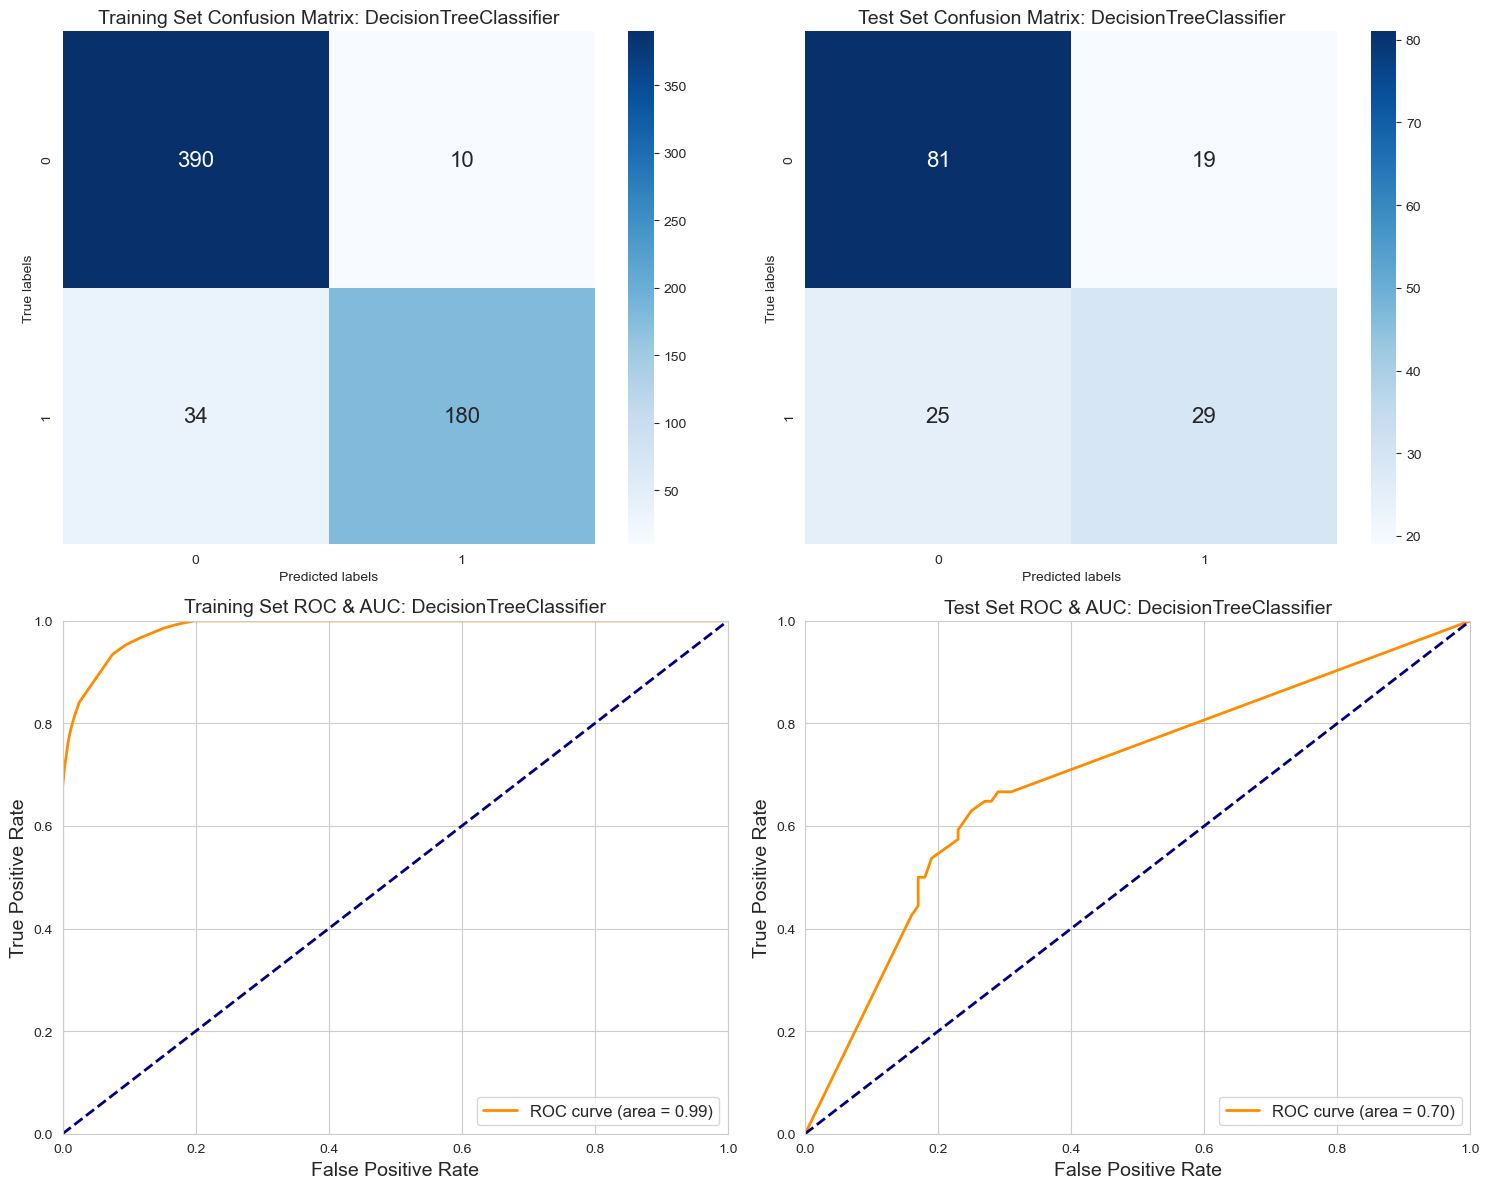

Classification Report for DecisionTreeClassifier Training Set:
              precision  recall  f1-score  support
0                  0.92    0.97      0.95   400.00
1                  0.95    0.84      0.89   214.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.93    0.91      0.92   614.00
weighted avg       0.93    0.93      0.93   614.00


Classification Report for DecisionTreeClassifier Test Set:
              precision  recall  f1-score  support
0                  0.76    0.81      0.79   100.00
1                  0.60    0.54      0.57    54.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.68    0.67      0.68   154.00
weighted avg       0.71    0.71      0.71   154.00
------------------------------------------------------------


In [31]:
best_logreg_model = evaluate_classifiers(X_train_processed, y_train, X_test_processed, y_test, classifiers, param_grid, cv_folds)

# Key takeaways:
1. KNN has overfit! if we want to work with this classifier, we need to take of it.

    1.1. Change algorithm

    1.2. Try the following method to take care of overfit:
    
        * Feature selection (FFS, P value)
        * Feature scaling - Process the data differently
        * Dimensionality Reduction - PCA
        * Cross Validation (CV)
        * Remove more outliers
        * Try to add more data

2. LogisticRegression has the best recall values. We'll continue with it.

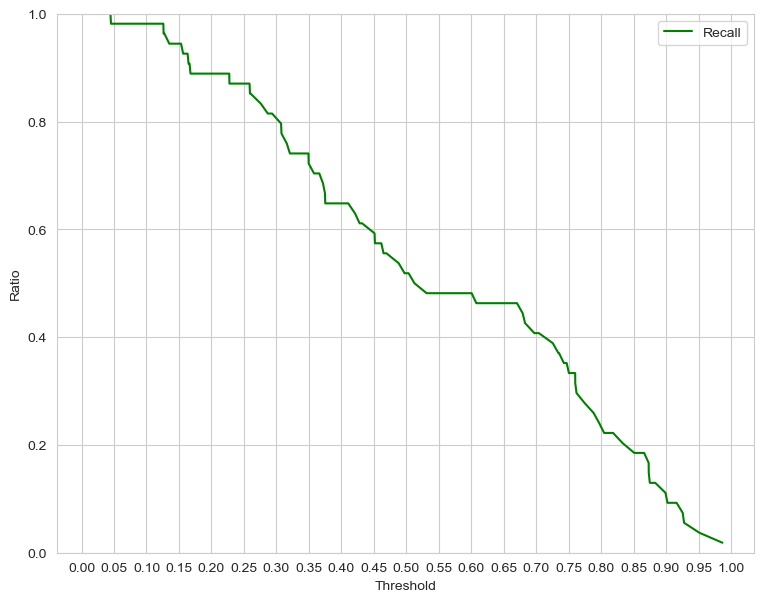

In [32]:
y_pred_proba = best_logreg_model.predict_proba(X_test_processed)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(9, 7))
# plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.ylabel('Ratio')
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0, 1])

# Set x-axis ticks
tick_interval = 0.05  # Set the desired interval for ticks
plt.xticks(np.arange(0, 1.01, tick_interval))  # Here, we assume the threshold range is [0, 1]

plt.show()


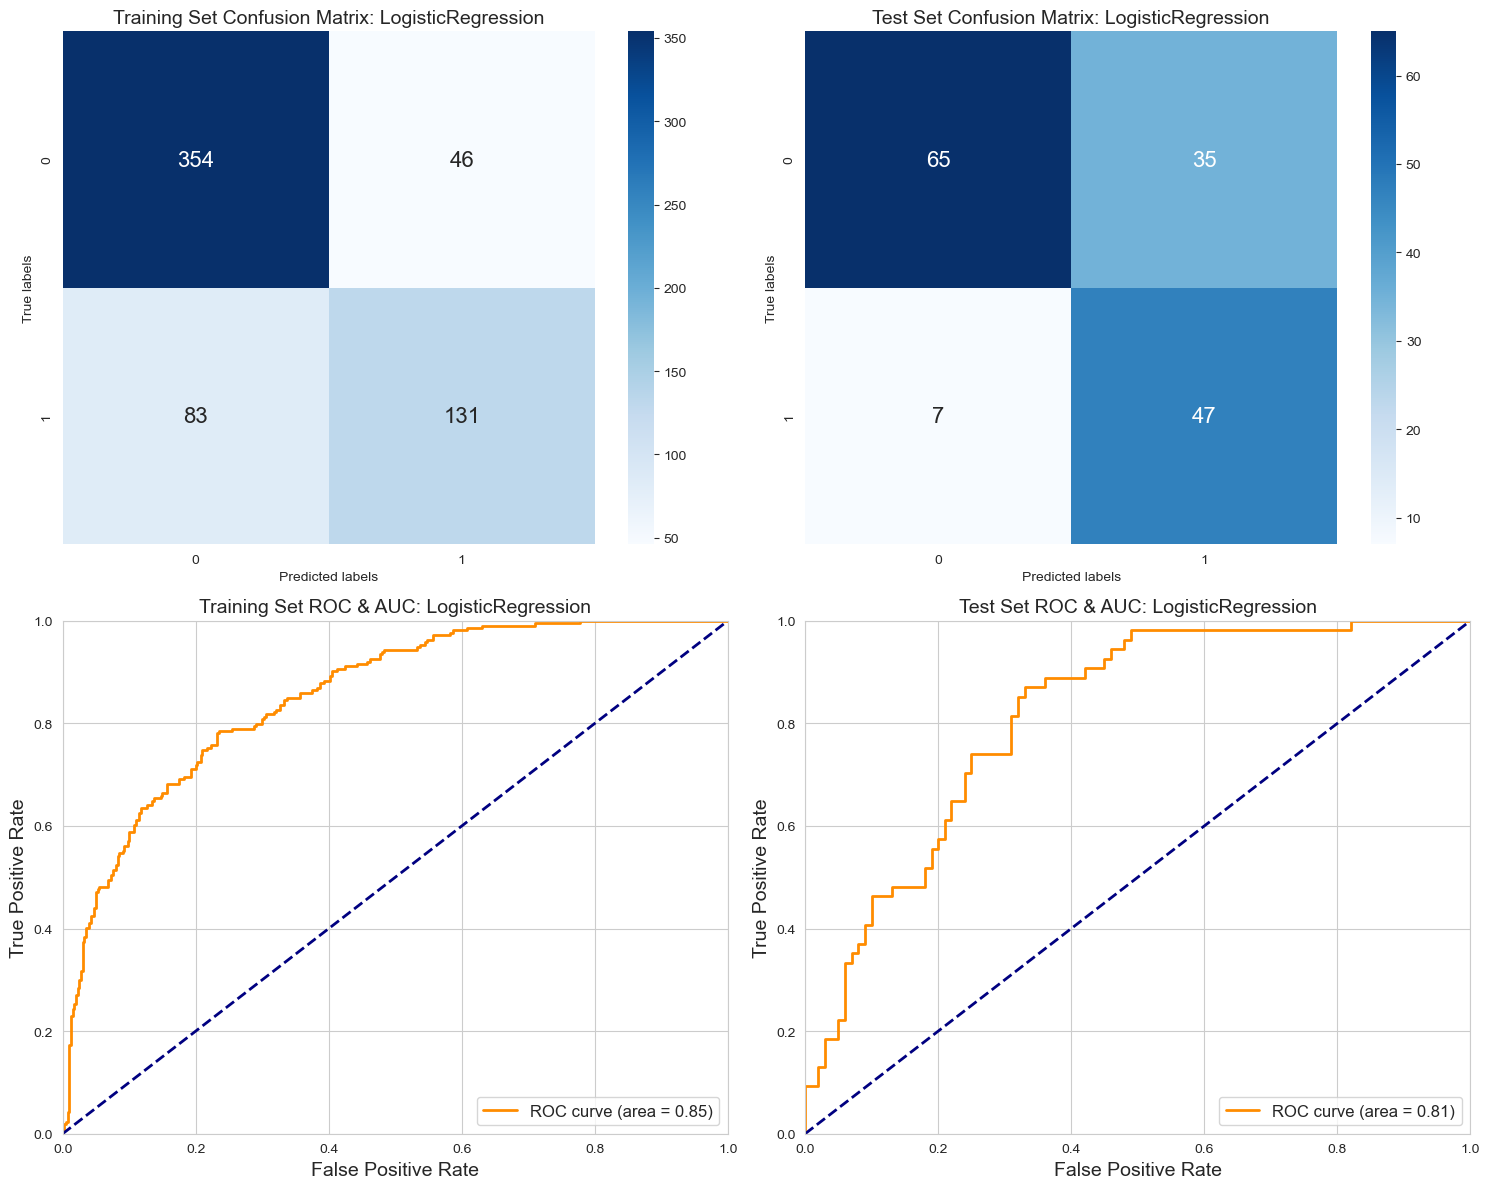

Classification Report for LogisticRegression Training Set:
              precision  recall  f1-score  support
0                  0.81    0.89      0.85   400.00
1                  0.74    0.61      0.67   214.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.78    0.75      0.76   614.00
weighted avg       0.79    0.79      0.78   614.00


Classification Report for LogisticRegression Test Set:
              precision  recall  f1-score  support
0                  0.90    0.65      0.76   100.00
1                  0.57    0.87      0.69    54.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.74    0.76      0.72   154.00
weighted avg       0.79    0.73      0.73   154.00
------------------------------------------------------------


In [33]:
# Predictions on the training set
y_train_pred = best_logreg_model.predict(X_train_processed)
y_train_pred_proba = best_logreg_model.predict_proba(X_train_processed)[:, 1]

# Predictions on the test set
y_test_pred = best_logreg_model.predict(X_test_processed)
y_test_pred_proba = best_logreg_model.predict_proba(X_test_processed)[:, 1]

# Apply the optimal threshold to get binary predictions for the test set
optimal_threshold = 0.23  # Replace with your actual optimal threshold
y_test_pred_optimal_threshold = (y_test_pred_proba >= optimal_threshold).astype(int)

# Use the plot_evaluation_metrics function with the predictions made with the new threshold value
plot_evaluation_metrics(
    clf_name='LogisticRegression',
    y_true_train=y_train,
    y_pred_train=y_train_pred,
    y_pred_proba_train=y_train_pred_proba,
    y_true_test=y_test,
    y_pred_test=y_test_pred_optimal_threshold,
    y_pred_proba_test=y_test_pred_proba
)


In [34]:
# Define the pipeline that includes FFS and KNN
pipeline = Pipeline([
    ('ffs', SequentialFeatureSelector(KNeighborsClassifier(), direction='forward')),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for PCA and KNN
param_grid = {
    'ffs__n_features_to_select': range(1, 8),  # Select between 1 and 7 features
    'ffs__estimator__n_neighbors': range(3, 8), 
    'knn__n_neighbors': range(1, 9, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_train_processed, y_train)

# Extract the best estimator
best_knn_model = grid_search.best_estimator_


y_train_pred = best_knn_model.predict(X_train_processed)
y_train_pred_proba = best_knn_model.predict_proba(X_train_processed)[:, 1]
y_pred = best_knn_model.predict(X_test_processed)
y_pred_proba = best_knn_model.predict_proba(X_test_processed)[:, 1]

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


In [35]:
# Get the best parameters
best_parameters = grid_search.best_params_
print("Best parameters found:", best_parameters)

Best parameters found: {'ffs__estimator__n_neighbors': 5, 'ffs__n_features_to_select': 6, 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


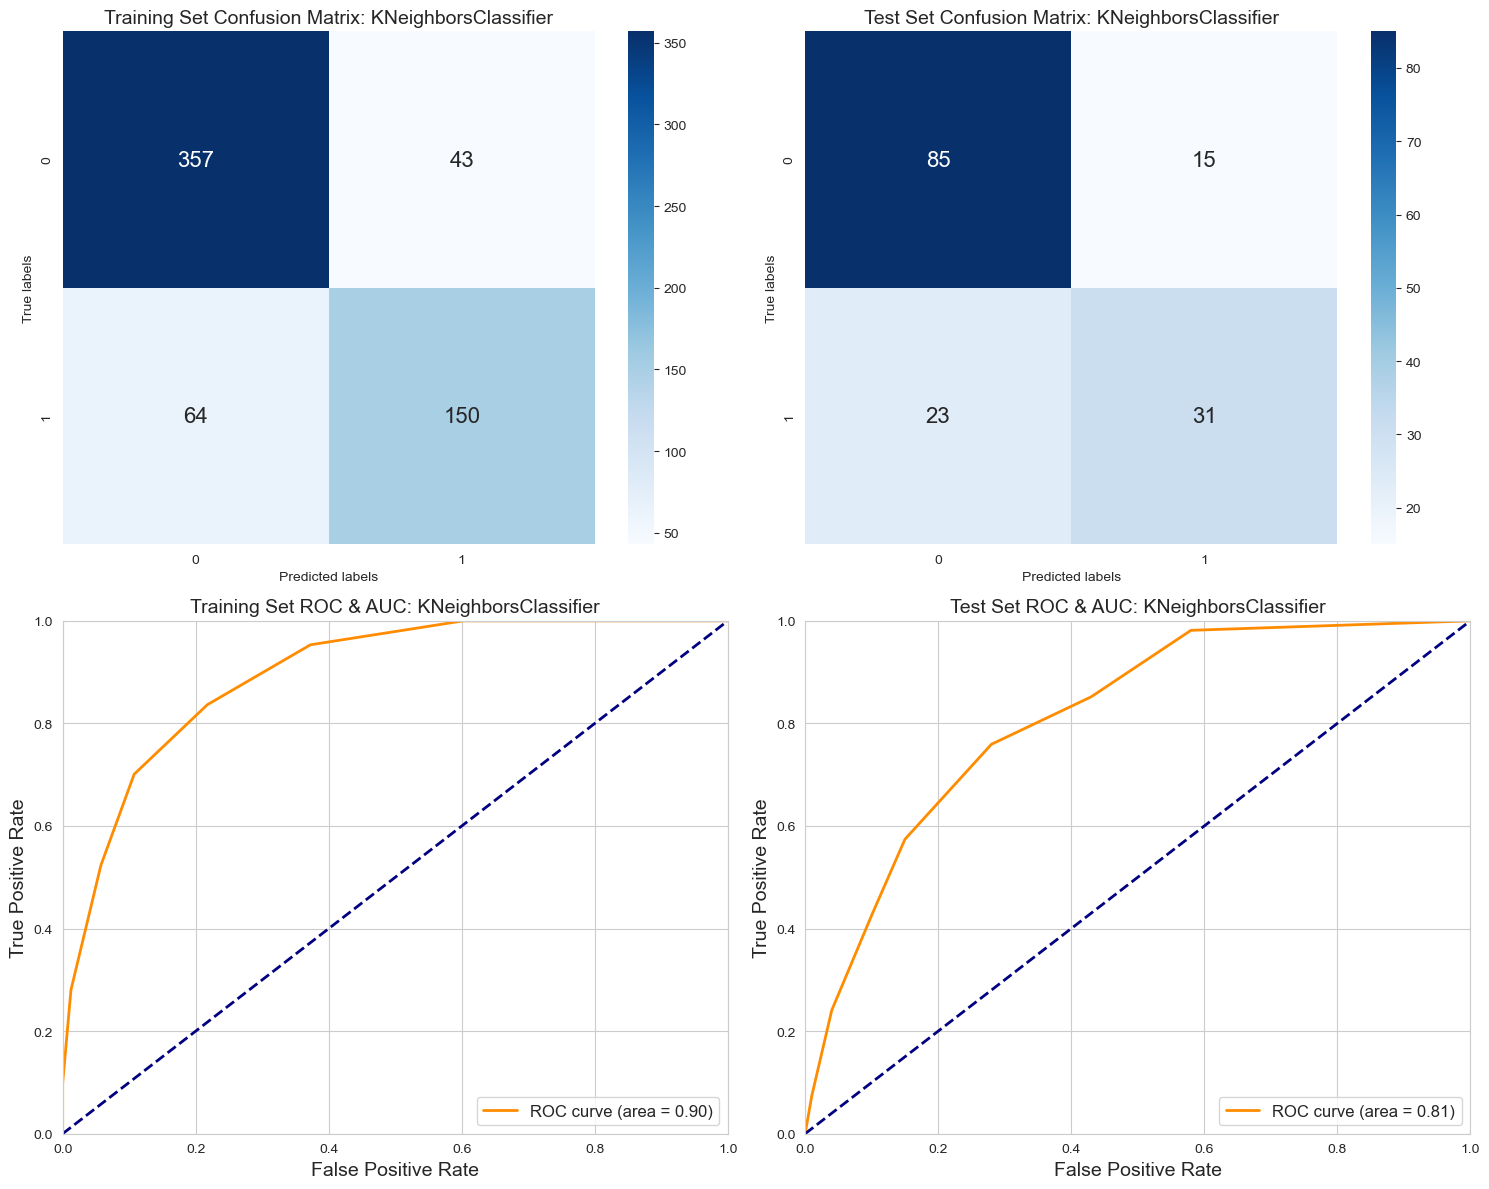

Classification Report for KNeighborsClassifier Training Set:
              precision  recall  f1-score  support
0                  0.85    0.89      0.87   400.00
1                  0.78    0.70      0.74   214.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.81    0.80      0.80   614.00
weighted avg       0.82    0.83      0.82   614.00


Classification Report for KNeighborsClassifier Test Set:
              precision  recall  f1-score  support
0                  0.79    0.85      0.82   100.00
1                  0.67    0.57      0.62    54.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.73    0.71      0.72   154.00
weighted avg       0.75    0.75      0.75   154.00
------------------------------------------------------------


In [36]:
plot_evaluation_metrics(
    clf_name='KNeighborsClassifier',
    y_true_train=y_train,
    y_pred_train=y_train_pred,
    y_pred_proba_train=y_train_pred_proba,
    y_true_test=y_test,
    y_pred_test=y_pred,
    y_pred_proba_test=y_pred_proba 
)

## Deployment

Overall we can see that LogisticRegression and KNN show the same results. 

However, We'll choose LogisticRegression. Why? Observe KNN results, there's a grat difference between the training and test results. Altough training results of KNN are not a "perfect" 100%, it's still pretty high, and the test results are lower than that. Observing the reuslts of LogisitcRegression, we can see that the difference between the training and test results are not that different. Thus, we'll choose LogisticRegression model. 

We've seen that LogisticRegression with the threshold value are giving the wanted results. 

We'll save them to file and ready for deployment

In [37]:
# Create a dictionary with the objects
model_data = {
    'model': best_logreg_model,
    'threshold': optimal_threshold
}

# Save the dictionary into one file
joblib.dump(model_data, 'model_and_threshold.joblib')


['model_and_threshold.joblib']